# Neuron selection & dissimilarity computation
* Notebook for contains code for preprocessing spike trains from V1 and AL. 
* Preprocessing steps:
    * Remove neurons with high variance across trials (using reliability score)
    * Remove neurons that have uniform firing rate across time (using clustering + average standard deviation)
* Computes the total dissimilarity matrix among the selected spike trains.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
from scipy.io import loadmat
import pandas as pd

from itertools import combinations

In [2]:
import functions as fn

In [3]:
def plot_raster(Region_st, neuron, ax = None, show_stimulus_line = True):
    spike_times = [Region_st[neuron]["stimulus_1"][i].tolist()[0] for i in range(20)]
    ax = ax or plt.gca()
    ax.eventplot(spike_times, color = "black", linewidth = 3, linelengths = 1.2)
    stimulus_line = 0
    if show_stimulus_line == True:
        while stimulus_line <425:
            ax.vlines(stimulus_line, -1, 20, linestyles = "dashed", color = "grey")
            stimulus_line += 53.25
    ax.set_xlim((0, 426))
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

# 0. Open data

In [4]:
# Do the same with V1
x = loadmat('../data/20160809/Combo3_V1.mat', struct_as_record=False)
num_neurons = x['ROI'].shape[2]

In [53]:
# Create a dictionary of dataframe
V1_st = {}
V1_gray = {}
st_col_name = ['stimulus_1','stimulus_2','stimulus_3']
gray_col_name = ['gray_1','gray_2','gray_3']

for i in range(num_neurons):
    V1_st[i]=pd.DataFrame(data = x['spiketrain'][0,i].st, 
                  columns = st_col_name)
    V1_gray[i]= pd.DataFrame(data = x['spiketrain'][0,i].st_gray,
                               columns = gray_col_name)

    
# Create dictionary of dataframe that contains spike frequency 
V1_freq_st = {}
V1_freq_gray = {}

for i in range(num_neurons):
    Z = np.zeros((20,3))
    for (j,k) in np.ndenumerate(V1_st[i]):
        Z[j] = k.shape[1]
    V1_freq_st[i] = pd.DataFrame(data = Z, columns = st_col_name)
    
    Z = np.zeros((20,3))
    for (j,k) in np.ndenumerate(V1_gray[i]):
        Z[j] = k.shape[1]
    V1_freq_gray[i] = pd.DataFrame(data = Z, columns = gray_col_name)    
    
# compute average firing times per neuron, per stimulus
V1_st_ave_1 = []
V1_st_ave_2 = []
V1_st_ave_3 = []

V1_gray_ave_1 = []
V1_gray_ave_2 = []
V1_gray_ave_3 = []

for i in range(num_neurons):
    M = V1_freq_st[i].mean()
    V1_st_ave_1.append(M[0])
    V1_st_ave_2.append(M[1])
    V1_st_ave_3.append(M[2])
    
    M = V1_freq_gray[i].mean()
    V1_gray_ave_1.append(M[0])
    V1_gray_ave_2.append(M[1])
    V1_gray_ave_3.append(M[2])

    
freq_data = {'stimulus_1': V1_st_ave_1, 'stimulus_2': V1_st_ave_2, 'stimulus_3': V1_st_ave_3,
            'gray_1': V1_gray_ave_1, 'gray_2': V1_gray_ave_2, 'gray_3': V1_gray_ave_3}
    
V1_freq= pd.DataFrame(freq_data) 
# This is a dataframe whose (i, 'stimulus') gives the average number of firing times for 
# neuron i with given stimulus    


In [ ]:
# save all dataframe created so far


# with open('data/V1_st.pkl', 'wb') as f:
#     pickle.dump(V1_st, f)
    
# with open('data/V1_gray.pkl','wb') as f:
#     pickle.dump(V1_gray, f)
    
# with open('data/V1_freq_st.pkl','wb') as f:
#     pickle.dump(V1_freq_st, f)
    
# with open('data/V1_freq_gray.pkl','wb') as f:
#     pickle.dump(V1_freq_gray, f)

# V1_freq.to_csv('data/V1_freq.csv', index = False)  

Load data

In [3]:
with open('data/AL_st.pkl','rb') as f:
    AL_st = pickle.load(f)
    
with open('data/AL_st_raster.pkl','rb') as f:
    AL_raster = pickle.load(f)
    
with open('data/V1_st.pkl','rb') as f:
    V1_st = pickle.load(f)
    
with open('data/V1_st_raster.pkl','rb') as f:
    V1_raster = pickle.load(f)

Create raster

In [6]:
V1_raster = fn.create_raster(V1_st, 426, ['stimulus_1', 'stimulus_2', 'stimulus_3'])
AL_raster = fn.create_raster(AL_st, 426, ['stimulus_1', 'stimulus_2', 'stimulus_3'])

# 1 bin corresponds to 0.07512 seoncds 

In [7]:
n_AL = len(AL_st)
n_V1 = len(V1_st)

print("Total number of neurons in V1: %d" %n_V1)
print("Total number of neurons in AL: %d" %n_AL)

Total number of neurons in V1: 352
Total number of neurons in AL: 163


# 1. Select V1 neurons

## 1.1 Select neurons based on reliability score

In [8]:
neurons_idx = list(range(n_V1))

# compute reliability score
reliability_score = []
for neuron in neurons_idx:
    score = fn.compute_reliability(V1_raster,'stimulus_1',neuron)
    reliability_score.append(score)

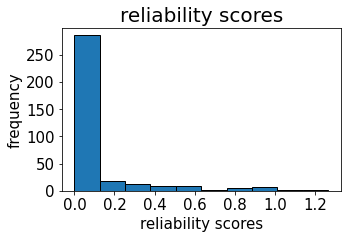

In [54]:
# visualize
plt.figure(figsize = (5,3))
plt.hist(reliability_score, bins = 10, edgecolor="black")
plt.title('reliability scores', fontsize = 20)
plt.xlabel("reliability scores", fontsize = 15)
plt.ylabel("frequency", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig("figures/V1_reliability.pdf", bbox_inches='tight')
plt.show()

number of neurons selected:  55
reliability score:  0.19485900382590737
rotation:  0


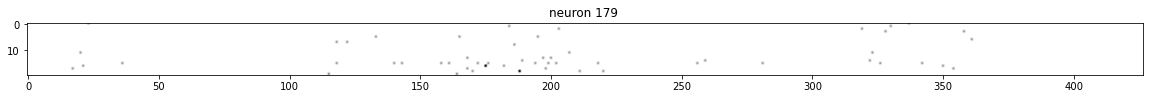

reliability score:  0.18556242917415844
rotation:  0


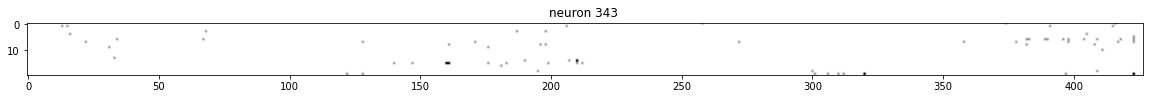

reliability score:  0.1799476442914031
rotation:  0


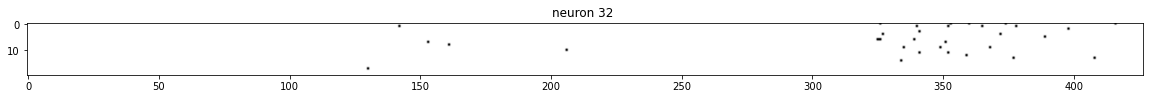

reliability score:  0.17113370126145824
rotation:  0


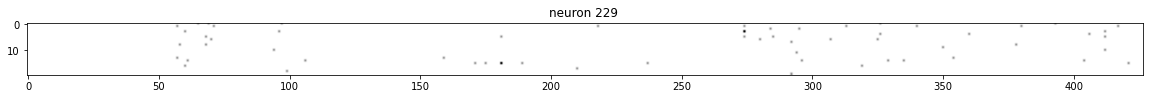

reliability score:  0.17002040318826125
rotation:  0


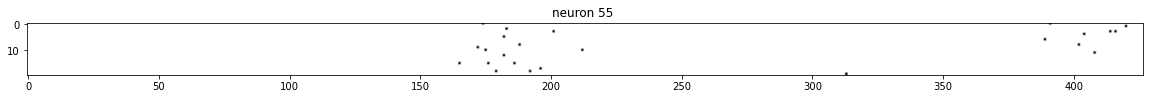

In [10]:
# select threshold for reliability score
cutoff = 0.2

low_reliability_neurons = [idx for idx, x in enumerate(reliability_score) if x < cutoff]
reliability_selected_neurons = [x for x in neurons_idx if x not in low_reliability_neurons]

print('number of neurons selected: ',len(reliability_selected_neurons))
# show example rasters of neurons that were removed
# show the rasters for neurons with highest reliability scores (among the neurons that were removed)

removed_reliability = [x for x in reliability_score if x < cutoff]
removed_reliability.sort()
removed_reliability = removed_reliability[::-1]

for i in range(5):
    index = reliability_score.index(removed_reliability[i])
    print('reliability score: ', removed_reliability[i])
    fn.show_raster(V1_raster,'stimulus_1',[index])

In [11]:
# plot example spike trains with high reliability
high_reliability_neurons = [idx for idx, x in enumerate(reliability_score) if x > 0.8]
print(high_reliability_neurons)


[43, 88, 100, 103, 109, 160, 164, 181, 183, 206, 267, 285, 309, 310, 315, 333]


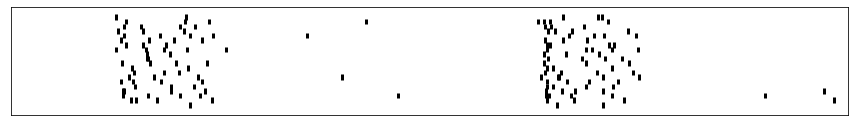

In [20]:
neuron = 43
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
#plt.savefig("V1_high_reliability_" + str(neuron) + ".svg")
plt.savefig("figures/V1_high_reliability_" + str(neuron) + ".pdf")
plt.show()

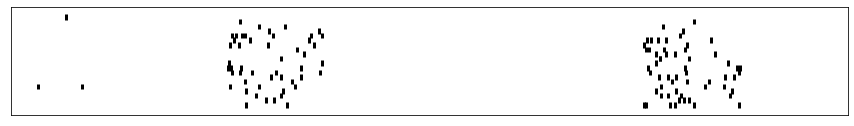

In [21]:
neuron = 88
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
#plt.savefig("V1_high_reliability_" + str(neuron) + ".svg")
plt.savefig("figures/V1_high_reliability_" + str(neuron) + ".pdf")
plt.show()

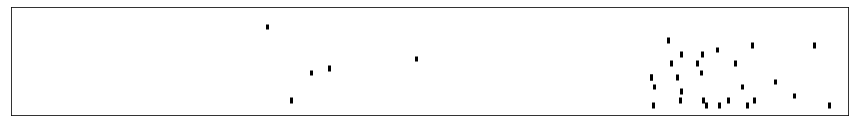

In [22]:
# plot example spike trains with low reliability
neuron = 32
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
#plt.savefig("V1_low_reliability_" + str(neuron) + ".svg")
plt.savefig("figures/V1_low_reliability_" + str(neuron) + ".pdf")
plt.show()

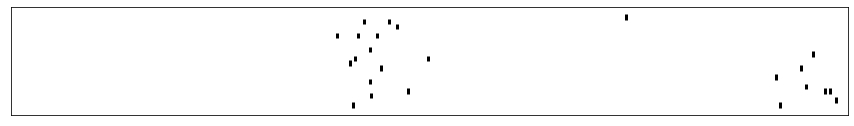

In [23]:
# plot example spike trains with low reliability
neuron = 55
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
#plt.savefig("V1_low_reliability_" + str(neuron) + ".svg")
plt.savefig("figures/V1_low_reliability_" + str(neuron) + ".pdf")
plt.show()

## 1.2 Select neuron based on average standard deviation  
* For each neuron, cluster the spike times, compute standard deviation of each cluster, and find average

Example clustering of spikes in a neuron 14

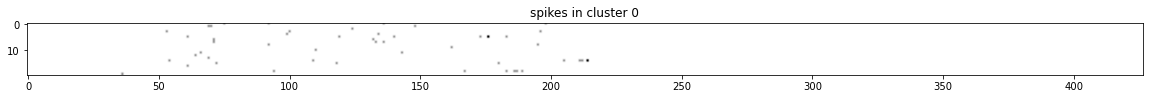

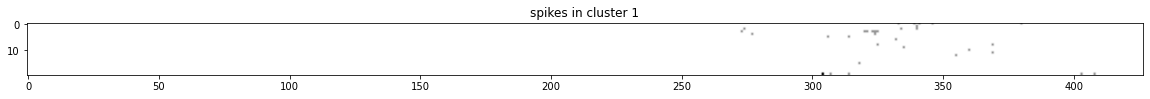

In [24]:
spike_cluster, avg_std, max_std = fn.compute_avg_std(V1_st, V1_raster,'stimulus_1',14, reliability_selected_neurons, 
                                                     eps = 40, min_samples = 15)
label_values = spike_cluster.keys()
for label in label_values:
    plt.figure(figsize = (20, 5))
    plt.title('spikes in cluster %d' %label)
    plt.imshow(spike_cluster[label], cmap = 'Greys')

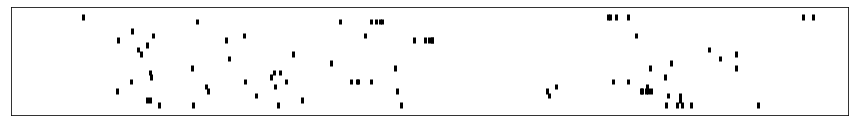

In [29]:
# plot example spike trains with low reliability
neuron = 14
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
plt.savefig("figures/V1_" + str(neuron) + ".pdf")
plt.show()

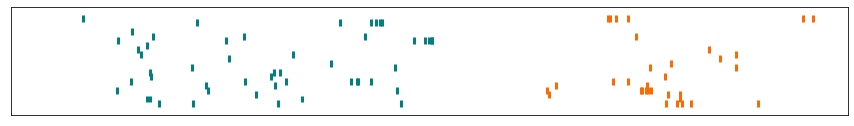

In [33]:
# plot cluster 0 
# note that spikes in cluster 0 occur before 250, and spikes in cluster 1 occur after. 
fig, ax = plt.subplots(figsize = (15, 2))
spike_times0 = [[j for j in V1_st[14]["stimulus_1"][i].tolist()[0] if j <250] for i in range(20)]
spike_times1 = [[j for j in V1_st[14]["stimulus_1"][i].tolist()[0] if j >250] for i in range(20)]
ax.eventplot(spike_times0, color = "#008080", linelengths = 1.5, linewidth = 3)
ax.eventplot(spike_times1, color = "#fc6a03", linelengths = 1.5, linewidth = 3)
ax.set_xlim((0, 426))
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("figures/V1_neuron_" + str(neuron) + "_spike_clusters.pdf")
plt.show()

In [37]:
avg_std_list = []  
max_std_list = []
for neuron in reliability_selected_neurons:
    spike_cluster, avg_std, max_std= fn.compute_avg_std(V1_st, V1_raster, 'stimulus_1', neuron, reliability_selected_neurons, 
                                                        eps =40, min_samples = 20)
    avg_std_list.append(avg_std)
    max_std_list.append(max_std)

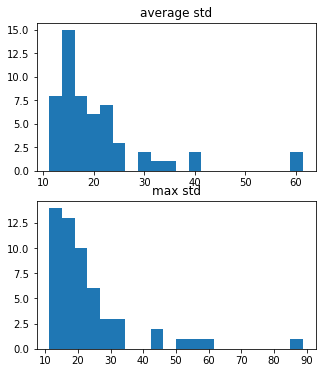

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (5, 6))
ax1.hist(avg_std_list, bins = 20)
ax1.set_title("average std")
ax2.hist(max_std_list, bins = 20)
ax2.set_title("max std")
plt.show()

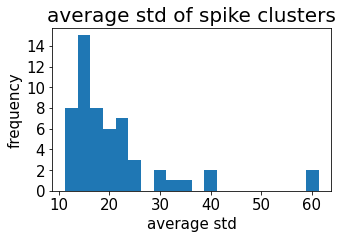

In [55]:
fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(avg_std_list, bins = 20)
ax.set_title("average std of spike clusters", fontsize = 20)
ax.set_xlabel("average std", fontsize = 15)
ax.set_ylabel("frequency", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig("figures/V1_avg_std.pdf", bbox_inches='tight')
plt.show()

selected number of neurons:  53
rotation:  0


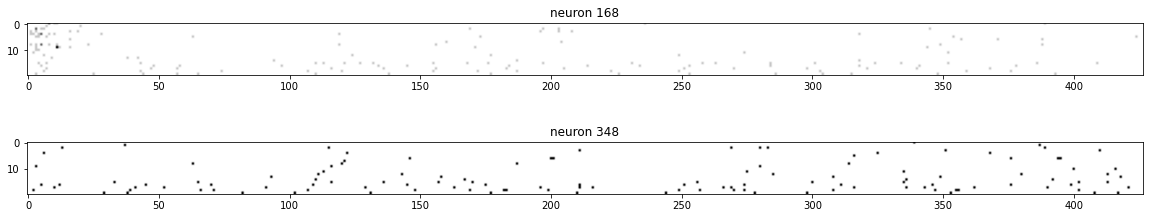

In [43]:
# remove neurons whose avg_std is NaN or larger than cutoff

avg_std_cutoff = 60

list_nan = [reliability_selected_neurons[idx] for idx, x in enumerate(avg_std_list) if np.isnan(x)]
remove = [x for x in reliability_selected_neurons if avg_std_list[reliability_selected_neurons.index(x)] > avg_std_cutoff] + list_nan
V1_selected_neurons = [x for x in reliability_selected_neurons if x not in remove]

# show rasters of removed neurons 
print('selected number of neurons: ', len(V1_selected_neurons))
fn.show_raster(V1_raster,'stimulus_1',remove)

In [44]:
# example spike trains with low average std

In [45]:
list_nan = [reliability_selected_neurons[idx] for idx, x in enumerate(avg_std_list) if np.isnan(x)]
high_avgstd = [x for x in reliability_selected_neurons if avg_std_list[reliability_selected_neurons.index(x)] < 15] + list_nan
print(high_avgstd)

[3, 7, 18, 81, 88, 98, 109, 115, 160, 181, 239, 269, 291, 308, 347]


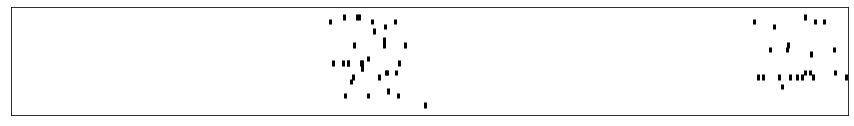

In [46]:
# plot example spike trains with high average std
neuron = 291
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
plt.savefig("figures/V1_neuron_low_avg_std_" + str(neuron) + ".pdf")
plt.show()

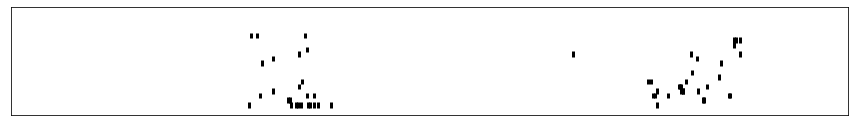

In [48]:
# plot example spike trains with high average std
neuron = 347
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
plt.savefig("figures/V1_neuron_low_avg_std" + str(neuron) + ".pdf")
plt.show()

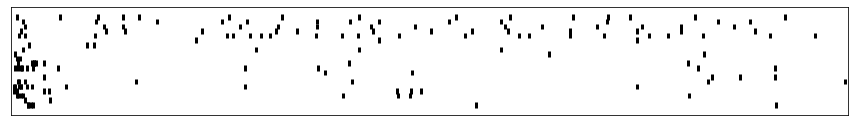

In [51]:
# plot example spike trains with high average std
neuron = 168
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
plt.savefig("figures/V1_neuron_high_avg_std_" + str(neuron) + ".pdf")
plt.show()

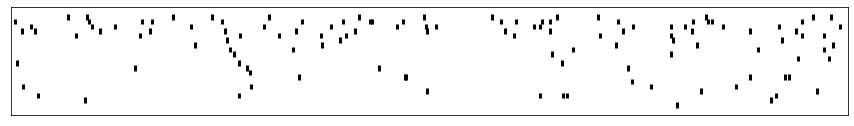

In [52]:
# plot example spike trains with high average std
neuron = 348
fig, ax = plt.subplots(figsize = (15,2))
ax = plot_raster(V1_st, neuron, show_stimulus_line = False)
plt.savefig("figures/V1_neuron_high_avg_std" + str(neuron) + ".pdf")
plt.show()

In [12]:
#f = open('V1_neurons_idx.txt','w+')
#for item in V1_selected_neurons:
#    f.write(str(item)+'\n')
#f.close()

# 2. Select AL neurons

## 2.1 Select neurons based on reliability score

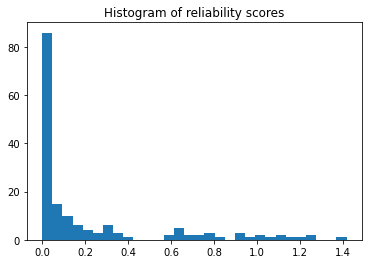

In [13]:
neurons_idx = list(range(n_AL))

# compute reliability score
reliability_score = []
for neuron in neurons_idx:
    score = fn.compute_reliability(AL_raster,'stimulus_1',neuron)
    reliability_score.append(score)

# visualize
plt.hist(reliability_score, bins = 30)
plt.title('Histogram of reliability scores')
plt.show()

number of neurons selected:  44
reliability score:  0.19597674626996636
rotation:  0


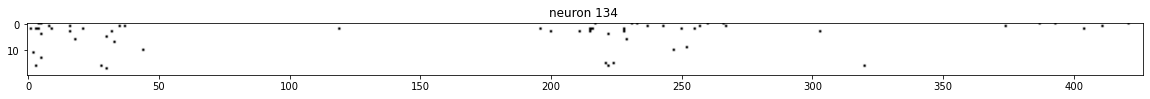

reliability score:  0.19491309360439776
rotation:  0


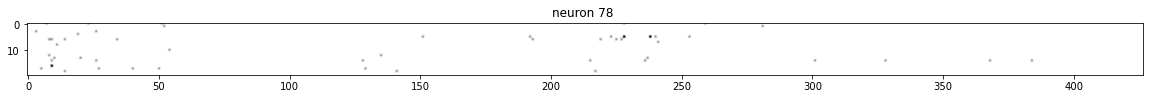

reliability score:  0.18387301623871935
rotation:  0


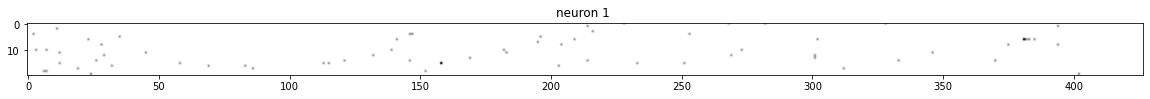

reliability score:  0.16920892920650027
rotation:  0


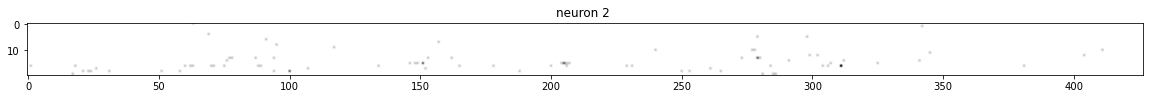

reliability score:  0.157205770837143
rotation:  0


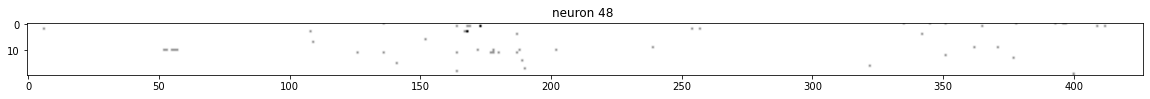

In [14]:
# decide on neurons with low reliability score
cutoff = 0.2

low_reliability_neurons = [idx for idx, x in enumerate(reliability_score) if x < cutoff]
reliability_selected_neurons = [x for x in neurons_idx if x not in low_reliability_neurons]

print('number of neurons selected: ',len(reliability_selected_neurons))
# show example rasters of neurons that were removed
# show the rasters for neurons with highest reliability scores (among the neurons that were removed)

removed_reliability = [x for x in reliability_score if x < cutoff]
removed_reliability.sort()
removed_reliability = removed_reliability[::-1]

for i in range(5):
    index = reliability_score.index(removed_reliability[i])
    print('reliability score: ', removed_reliability[i])
    fn.show_raster(AL_raster,'stimulus_1',[index])

## 2.2 Select neuron based on average standard deviation  
* For each neuron, cluster the spike times, compute standard deviation of each cluster, and find average

Example clustering of spike times in a neuron

/Users/irisyoon/opt/anaconda3/envs/neuro_matching/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/irisyoon/opt/anaconda3/envs/neuro_matching/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


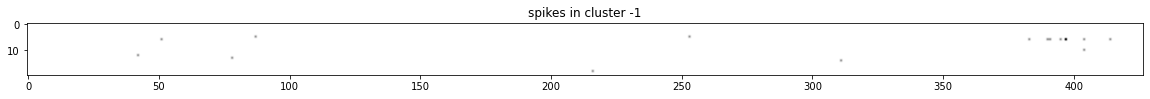

In [15]:
spike_cluster, avg_std, max_std = fn.compute_avg_std(AL_st, AL_raster,'stimulus_1',14, reliability_selected_neurons, 
                                                     eps = 40, min_samples = 15)
label_values = spike_cluster.keys()
for label in label_values:
    plt.figure(figsize = (20, 5))
    plt.title('spikes in cluster %d' %label)
    plt.imshow(spike_cluster[label], cmap = 'Greys')

In [16]:
avg_std_list = [] 
max_std_list = []
for neuron in reliability_selected_neurons:
    spike_cluster, avg_std, max_std= fn.compute_avg_std(AL_st, AL_raster, 'stimulus_1', neuron, reliability_selected_neurons, 
                                                        eps =40, min_samples = 20)
    avg_std_list.append(avg_std)
    max_std_list.append(max_std)

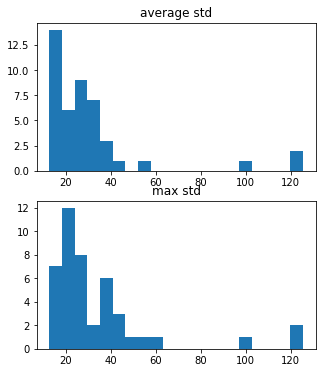

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (5, 6))
ax1.hist(avg_std_list, bins = 20)
ax1.set_title("average std")
ax2.hist(max_std_list, bins = 20)
ax2.set_title("max std")
plt.show()

selected number of neurons:  41
rotation:  0


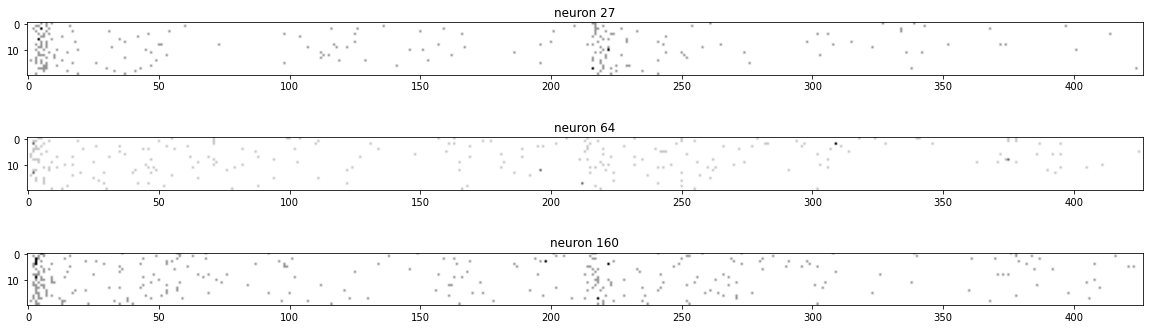

In [18]:
# remove neurons whose avg_std is NaN or larger than cutoff

avg_std_cutoff = 60

list_nan = [reliability_selected_neurons[idx] for idx, x in enumerate(avg_std_list) if np.isnan(x)]
remove = [x for x in reliability_selected_neurons if avg_std_list[reliability_selected_neurons.index(x)] > avg_std_cutoff] + list_nan
AL_selected_neurons = [x for x in reliability_selected_neurons if x not in remove]

# show rasters of removed neurons 
print('selected number of neurons: ', len(AL_selected_neurons))
fn.show_raster(AL_raster,'stimulus_1',remove)

In [33]:
f = open('AL_neurons_idx.txt','w+')
for item in AL_selected_neurons:
    f.write(str(item)+'\n')
f.close()

rotation:  0


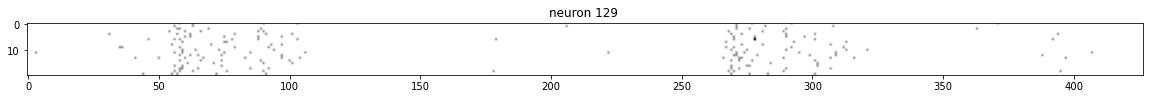

In [27]:
# plot example of removed neurons and good neurons (to include in slides)

fn.show_raster(AL_raster, "stimulus_1", [129], save_fig = "AL_neuron129.png")

# 3. Compute distances

In [4]:
f = open("data/V1_neurons_idx.txt", "r")
V1_selected_neurons =[int(line.split(',')[0]) for line in f.readlines()]

f = open("data/AL_neurons_idx.txt", "r")
AL_selected_neurons =[int(line.split(',')[0]) for line in f.readlines()]

In [5]:
V1_neurons_idx = V1_selected_neurons
AL_neurons_idx = AL_selected_neurons

## 3.1 Compute distances among V1

In [19]:
V1_sim, V1_distance = fn.limited_xcorr(V1_raster,'stimulus_1', V1_neurons_idx, 50)

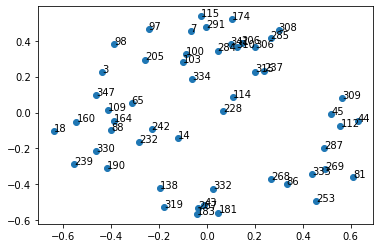

In [20]:
# visualize
fn.vis_embedding(V1_distance, V1_neurons_idx)

## 3.2 Compute distances among AL

In [21]:
AL_sim, AL_distance = fn.limited_xcorr(AL_raster,'stimulus_1', AL_neurons_idx, 50)

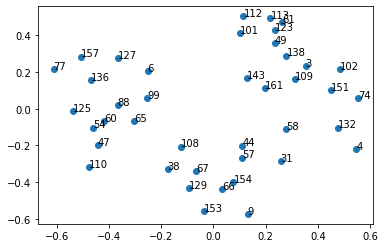

In [22]:
# visualize
fn.vis_embedding(AL_distance, AL_neurons_idx)

## 3.3 Compute the cross-dissimilarity matrix

In [6]:
# This computes the total dissimiarity matrix. 
# The first rows and columns correspond to V1. The last rows and columns correspond to AL
x_max, x_sim, x_distance = fn.limited_xcorr_V1_AL(V1_raster, V1_neurons_idx, AL_raster, AL_neurons_idx, 'stimulus_1',50)

# save
#np.savetxt("total_dissimilarity.csv",x_distance)

In [7]:
x_sim

array([[0.        , 0.2637057 , 0.39976447, ..., 0.24627182, 0.013829  ,
        0.6412228 ],
       [0.2637057 , 0.        , 0.30903285, ..., 0.09655332, 0.17273166,
        0.55785349],
       [0.39976447, 0.30903285, 0.        , ..., 0.49991097, 0.19015707,
        0.63734374],
       ...,
       [0.24627182, 0.09655332, 0.49991097, ..., 0.        , 0.2186064 ,
        0.47739174],
       [0.013829  , 0.17273166, 0.19015707, ..., 0.2186064 , 0.        ,
        0.25979698],
       [0.6412228 , 0.55785349, 0.63734374, ..., 0.47739174, 0.25979698,
        0.        ]])

In [8]:
x_max

33.0